In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

In [ ]:
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
pd.options.display.max_colwidth = 200
%matplotlib inline

In [ ]:
# You may load this given csv, or you may change this line to load some other csv
df = pd.read_csv('https://raw.githubusercontent.com/amey-kulkarni27/Datasets/main/images.csv')

## Visualising the Data

In [ ]:
text_sr = df.iloc[:, 1]

In [ ]:
for x in text_sr.iloc[:5]:
  print(x.split())

['Nayo', 'Women', 'Orange', '&', 'Off-White', 'Striped', 'Straight', 'Kurta']
['Jaipur', 'Kurti', 'Women', 'Navy', 'Blue', 'Yoke', 'Design', 'Kurta', 'with', 'Trousers']
['AHIKA', 'Women', 'Green', '&', 'Off-White', 'Printed', 'Straight', 'Kurta']
['ADA', 'Women', 'Yellow', '&', 'White', 'Chikankari', 'Hand', 'Embroidered', 'Semi-Sheer', 'Straight', 'Kurta']
['Soch', 'Women', 'Navy', 'Blue', '&', 'Grey', 'Dyed', 'Straight', 'Kurta']


In [ ]:
text_sr.head()

0                              Nayo Women Orange & Off-White Striped Straight Kurta
1                      Jaipur Kurti Women Navy Blue Yoke Design Kurta with Trousers
2                              AHIKA Women Green & Off-White Printed Straight Kurta
3    ADA Women Yellow & White Chikankari Hand Embroidered Semi-Sheer Straight Kurta
4                                   Soch Women Navy Blue & Grey Dyed Straight Kurta
Name: description, dtype: object

## Using the Natural Language Tool-Kit
We perform some text processing such as converting to lower case, removing stopwords, etc.


In [ ]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

In [ ]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [ ]:
normalize_corpus = np.vectorize(normalize_document)

### Removing Numbers and Punctuation

In [ ]:
from string import punctuation

remove_terms = punctuation + '0123456789'

## Text after preprocess steps are done

In [ ]:
# norm_text = [word.lower() for word in text_sr if word not in remove_terms]
norm_text = [[word.lower() for word in row.split() if word not in remove_terms] for row in text_sr]
norm_text = [' '.join(tok_sent) for tok_sent in norm_text]
filter_obj = filter(None, normalize_corpus(norm_text))
norm_text = [tok_sent for tok_sent in filter_obj if len(tok_sent.split()) > 2]
print(norm_text[:20])

print('Total lines:', len(text_sr.index))
print('\nSample line:', text_sr[0])
print('\nProcessed line:', norm_text[0])

['nayo women orange offwhite striped straight kurta', 'jaipur kurti women navy blue yoke design kurta trousers', 'ahika women green offwhite printed straight kurta', 'ada women yellow white chikankari hand embroidered semisheer straight kurta', 'soch women navy blue grey dyed straight kurta', 'soch women black yoke design aline kurta', 'ahika women maroon beige printed straight kurta', 'w women navy blue silver embroidered straight kurta', 'soch women navy blue goldcoloured printed straight kurta', 'herenow women navy yoke design aline kurta', 'aayna women beige self design kurta trousers', 'soch women lime green offwhite woven design straight kurta', 'yash gallery women black printed aline kurta', 'w women teal green solid straight kurta', 'global desi women teal blue red printed straight kurta', 'soch women offwhite blue printed aline kurta', 'indo era women beige pink yoke design kurta palazzos dupatta', 'ahika women sea green white printed straight kurta', 'indo era women navy blue

In [ ]:
embedding_dim = 512

## Word2Vec Gensim Model

In [ ]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_text]

# Set values for various parameters
feature_size = embedding_dim    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

In [ ]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['men', 'women', 'saree', 'kurta', 'blue', 'trousers']}
similar_words

{'blue': ['maroon', 'red', 'multicoloured', 'pink', 'purple'],
 'kurta': ['anouk', 'kurti', 'jompers', 'sojanya', 'libas'],
 'men': ['super', 'sport', 'reversible', 'short', 'nsw'],
 'saree': ['classicate', 'chanderi', 'silk', 'blissta', 'gosriki'],
 'trousers': ['palazzos', 'churidar', 'anarkali', 'skirt', 'sharara'],
 'women': ['layered', 'tiered', 'detail', 'stole', 'layer']}

## TSNE plot of some words

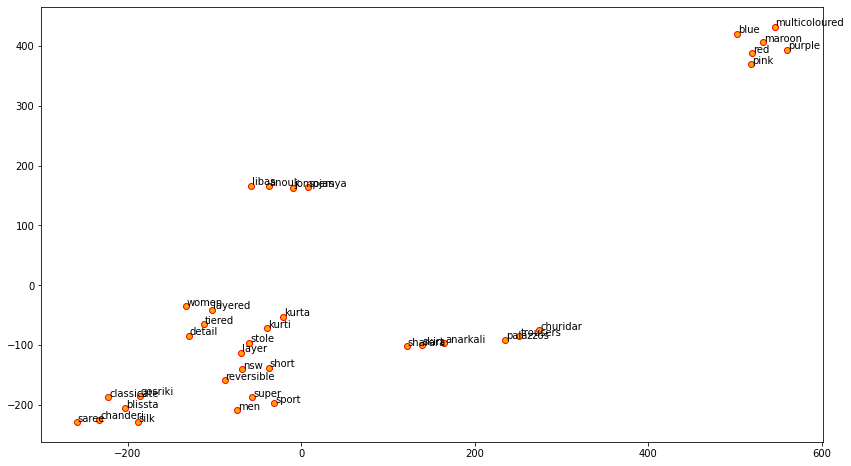

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [ ]:
# Weights vector for the word "women"
(w2v_model.wv['women'])

array([ 0.06487487, -0.21439433,  0.8371537 , -0.1267367 , -0.30280304,
       -0.3895257 ,  0.07759346, -0.19189307,  0.53699815,  0.23650353,
        0.9073476 , -0.44629586, -0.01102705,  0.05333566, -0.28294244,
        0.832696  , -0.14178604, -0.6496142 , -0.05357682,  0.5623325 ,
       -0.46982738,  0.9268761 ,  0.11124688, -0.48573908, -0.68636864,
        0.11378065, -0.7742986 , -0.8808748 , -0.94703907,  0.25060987,
       -0.8668714 ,  0.00641473, -0.35821468, -0.19851819,  0.46499127,
       -0.10297149, -0.39533988, -0.03515496, -0.2136224 , -0.4786116 ,
        0.8605316 ,  0.38794106, -0.13082522,  0.0089696 , -0.290847  ,
        0.8134691 , -0.16980027,  0.30322313, -0.4375453 , -0.7001477 ,
        0.1584059 ,  0.27784786, -0.80306387,  0.35443905, -0.1816355 ,
        0.3663004 ,  0.36935297,  0.29328904, -0.06318628,  0.05841354,
        0.15126164,  0.49628162,  0.34300095,  0.13262367, -0.08328082,
       -0.54094166, -0.64495385, -0.17246765, -0.59215134, -0.44

## Storing into CSV

In [ ]:
import csv

In [ ]:
lst = []
for i in range(len(text_sr.index)):
  v = np.array([0. for i in range(embedding_dim)])
  l = 0
  for word in norm_text[i].split():
    v += w2v_model.wv[word]
    l += 1
  lst.append(v / l)

In [ ]:
with open("word2vec_gensim.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(lst)

### Just a check

In [ ]:
dfx = pd.read_csv('word2vec_gensim.csv', header = None)

In [ ]:
dfx.shape

(12305, 512)